In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
# https://drive.google.com/drive/folders/1YPqeTvOR4zWm0O0FL357mbJtLjx9FniY?usp=sharing
url='1YPqeTvOR4zWm0O0FL357mbJtLjx9FniY'
gdd.download_file_from_google_drive(file_id=url,dest_path='./data.zip',unzip=True)

Unzipping...

/usr/local/lib/python3.10/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1YPqeTvOR4zWm0O0FL357mbJtLjx9FniY" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']



In [5]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [6]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join("/content/drive/MyDrive/Brain Tumor dataset",'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Brain Tumor dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:14<00:00,  5.13it/s]


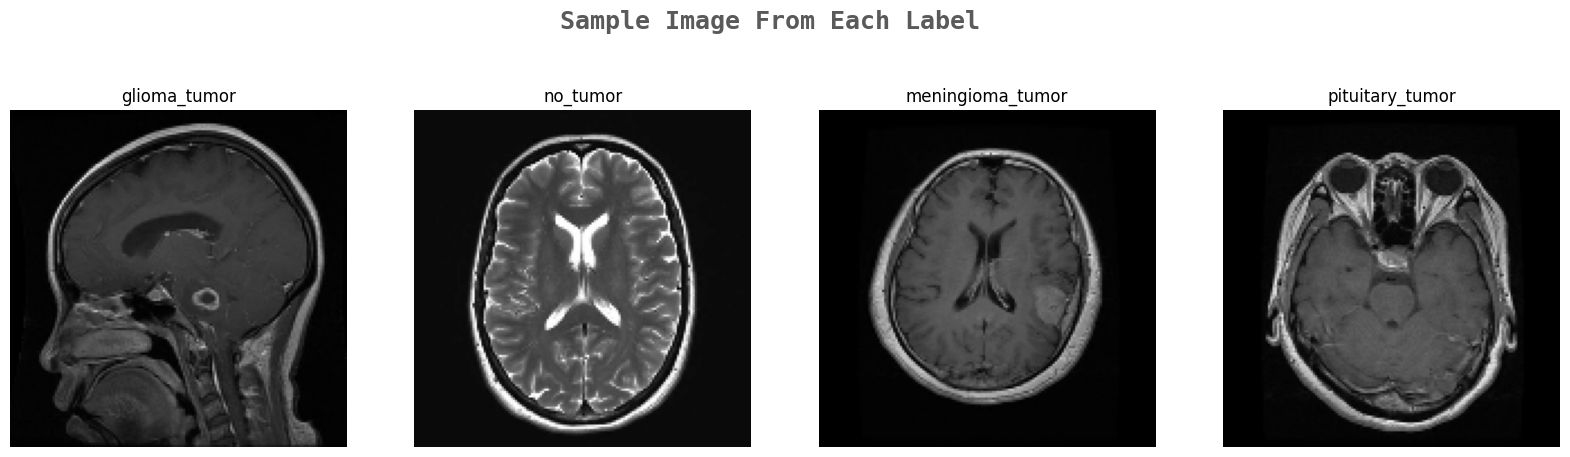

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [9]:
X_train.shape

(3274, 150, 150, 3)

In [10]:
# If random_state=0 shuffling goes out of control and we get differnet dataset for each execution
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
effnet = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
import numpy as np
from keras.preprocessing import image
from keras.applications import VGG16, ResNet50
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from keras.models import Model
from keras.layers import Input, Concatenate
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.layers import Dense
x = Dense(256, activation='relu')(combined)
num_classes=4
predictions = Dense(num_classes, activation='softmax')(x)

In [14]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [15]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [18]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)


In [20]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, batch_size=32,
                   callbacks=[checkpoint,reduce_lr])

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.8291
Epoch 1: val_accuracy did not improve from 0.78983
83/83 [==============================] - 18s 215ms/step - loss: 0.5106 - accuracy: 0.8291 - val_loss: 0.6542 - val_accuracy: 0.7898 - lr: 8.1000e-06
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.8303
Epoch 2: val_accuracy did not improve from 0.78983
83/83 [==============================] - 18s 220ms/step - loss: 0.5094 - accuracy: 0.8303 - val_loss: 0.6592 - val_accuracy: 0.7898 - lr: 8.1000e-06
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.8310
Epoch 3: val_accuracy did not improve from 0.78983

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
83/83 [==============================] - 18s 215ms/step - loss: 0.5036 - accuracy: 0.8310 - val_loss: 0.6677 - val_accuracy: 0.7898 - lr: 8.1000e-06
Epoch 4/20
83/83 [=======================

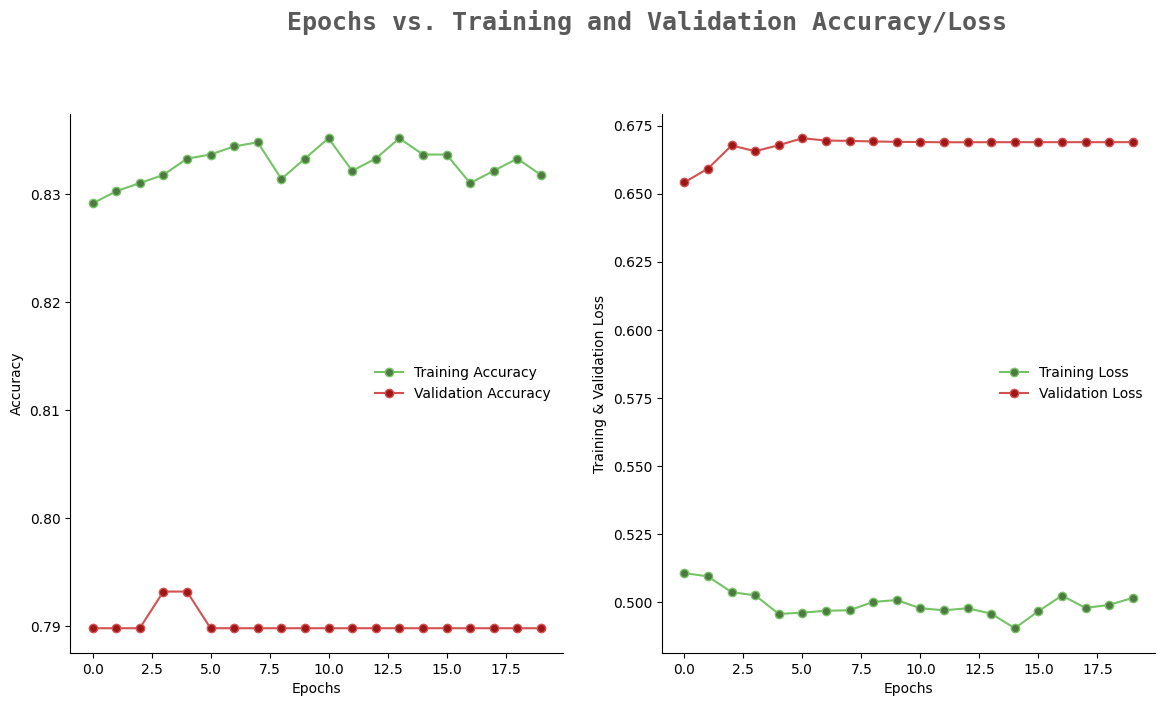

In [23]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [24]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 2s 148ms/step


In [25]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        97
           1       0.66      0.90      0.76        48
           2       0.77      0.69      0.73        94
           3       0.85      0.89      0.87        89

    accuracy                           0.81       328
   macro avg       0.80      0.82      0.81       328
weighted avg       0.82      0.81      0.81       328



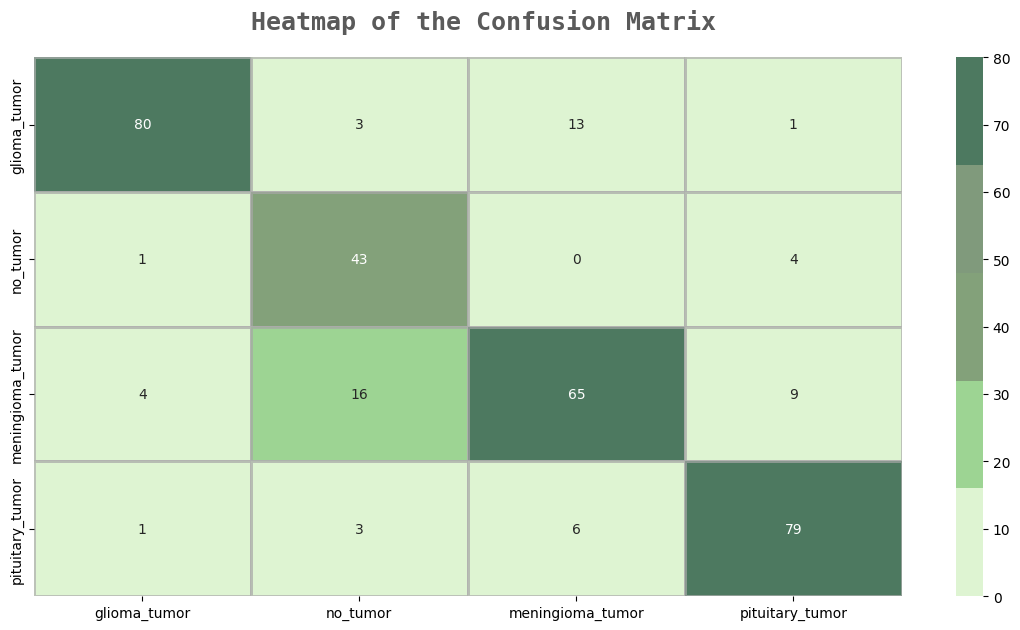

In [26]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [27]:
print(accuracy_score(y_test_new,pred))

0.8140243902439024


In [28]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [29]:
uploader = widgets.FileUpload()
display(uploader)


FileUpload(value={}, description='Upload')

In [30]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            content = uploader.value[list(uploader.value.keys())[0]]['content']
            img = Image.open(io.BytesIO(content))
            img.show()
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])